Here I implemet BERT with ktrain library. However, accuracies here are lower than using Hugging Face transformers library (in a separate code file).

In [ ]:
# download the repo to get access to data
!rm -rf DL-Kaggle-competition/
!git clone https://github.com/millasni/DL-Kaggle-competition/

Cloning into 'DL-Kaggle-competition'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 4), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip3 install ktrain
!pip3 install "tensorflow_gpu>=2.1.0"

In [ ]:
import pandas as pd
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import skorch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import backend as K # or from keras...?

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional,SpatialDropout1D,Concatenate
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D,Dropout,Flatten,Activation
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from keras import optimizers
from keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import ktrain

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import os

In [ ]:
train = pd.read_csv('DL-Kaggle-competition/train.csv') 
test = pd.read_csv('DL-Kaggle-competition/test.csv') 
text = pd.read_csv('DL-Kaggle-competition/text.csv') 
reference = pd.read_csv('DL-Kaggle-competition/reference.csv') 
cross_ref = pd.read_csv('DL-Kaggle-competition/ref_in_out.csv') 

In [ ]:
train.head()

,id,label
0,0,1
1,3,1
2,6,1
3,8,0
4,9,0


## Data pre-processing

In [ ]:
# One-hot encode the classes in the train
Y = to_categorical(train[['label']])
print(Y.shape)
print(Y[:5])

(12779, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
print(text.head())
text.shape # we have twice as many lines in text than in train

   id                                              title
0   0  interactive visual exploration of neighbor bas...
1   1  autodomainmine a graphical data mining system ...
2   2  anipqo almost non intrusive parametric query o...
3   3  relational division four algorithms and their ...
4   4  selection and ranking of text from highly impe...


(25561, 2)

In [ ]:
train = train.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
train.head(20)

,id,label,idtext,title
0,0,1,0,interactive visual exploration of neighbor bas...
1,3,1,3,relational division four algorithms and their ...
2,6,1,6,simplifying xml schema effortless handling of ...
3,8,0,8,funbase a function based information managemen...
4,9,0,9,inverted matrix efficient discovery of frequen...
5,11,2,11,computational aspects of covering in dominance...
6,13,4,13,feaspar a feature structure parser learning ...
7,18,0,18,assessing the scenic route measuring the value...
8,20,0,20,webanywhere enabling a screen reading interfac...
9,24,2,24,non standard semantics for the method of tempo...


In [ ]:
train.title.values[:20]

array(['interactive visual exploration of neighbor based patterns in data streams',
       'relational division four algorithms and their performance',
       'simplifying xml schema effortless handling of nondeterministic regular expressions',
       'funbase a function based information management system',
       'inverted matrix efficient discovery of frequent items in large datasets in the context of interactive mining',
       'computational aspects of covering in dominance graphs',
       'feaspar   a feature structure parser learning to parse spoken language',
       'assessing the scenic route measuring the value of search trails in web logs',
       'webanywhere enabling a screen reading interface for the web on any computer',
       'non standard semantics for the method of temporal arguments',
       'exsearch a novel vertical search engine for online barter business',
       'query evaluation and progression in aol knowledge bases',
       'cryptanalytic attacks on pseudora

In [ ]:
train = train[['id','label','title']]
train.head()

,id,label,title
0,0,1,interactive visual exploration of neighbor bas...
1,3,1,relational division four algorithms and their ...
2,6,1,simplifying xml schema effortless handling of ...
3,8,0,funbase a function based information managemen...
4,9,0,inverted matrix efficient discovery of frequen...


In [ ]:
test = test.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
test.head()

,id,idtext,title
0,1,1,autodomainmine a graphical data mining system ...
1,2,2,anipqo almost non intrusive parametric query o...
2,4,4,selection and ranking of text from highly impe...
3,5,5,conditional random fields for multi agent rein...
4,7,7,multi dimensional description logics


In [ ]:
test = test[['id','title']]
test.head()

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics


[[123, 239, 421, 2, 766, 9, 133, 5, 8, 176], [6586, 3, 407, 8, 35, 16, 1, 120, 75], [6587, 1896, 114, 3491, 859, 23, 75, 1, 1002, 244, 264], [49, 2612, 1299, 58, 4, 428, 57], [94, 4, 126, 2, 34, 24, 618, 1436, 3492, 1, 27, 2, 441, 170], [393, 265, 638, 1, 44, 225, 327, 14], [2432, 56, 210, 6588, 530, 2, 2142, 980, 476], [44, 200, 323, 515], [6589, 3, 346, 9, 17, 46, 16], [924, 568, 30, 156, 2, 484, 1626, 5, 45, 662, 5, 6, 106, 2, 123, 35]]
28


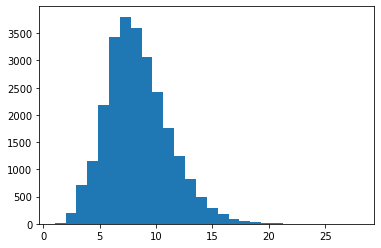

In [ ]:
# tokenize train data on the whole TEXT (train+test) to see the max sent_len - - for exploration only
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text.title)
t = tokenizer.texts_to_sequences(text.title)
print(t[:10])
print(len(max(t, key=len)))
sent_len = []
for i in t:
  sent_len.append(len(i))

plt.hist(sent_len,bins=28)
plt.show()

In [ ]:
# tokenize train data (on the whole set of labeled data)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.title)
X = tokenizer.texts_to_sequences(train.title)
print(X[:10])
X = pad_sequences(X, maxlen=20)
X[:10]
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)

[[132, 247, 402, 2, 834, 9, 126, 5, 8, 161], [44, 2099, 1325, 61, 4, 415, 58], [1865, 63, 213, 4596, 478, 2, 1866, 1444, 622], [4597, 3, 262, 9, 18, 51, 15], [1038, 531, 30, 214, 2, 429, 1228, 5, 45, 545, 5, 6, 122, 2, 132, 32], [248, 673, 2, 1686, 5, 1687, 180], [4598, 3, 127, 65, 389, 14, 7, 1229, 379, 27], [765, 6, 4599, 1688, 515, 6, 238, 2, 22, 2366, 5, 16, 928], [4600, 1230, 3, 4601, 1231, 304, 1, 6, 16, 10, 2367, 50], [130, 1039, 99, 1, 6, 72, 2, 75, 1689]]
Found 9321 unique tokens.
{'for': 1, 'of': 2, 'a': 3, 'and': 4, 'in': 5, 'the': 6, 'to': 7, 'data': 8, 'based': 9, 'on': 10, 'an': 11, 'with': 12, 'using': 13, 'learning': 14, 'system': 15, 'web': 16, 'database': 17, 'information': 18, 'systems': 19, 'query': 20, 'from': 21, 'search': 22, 'model': 23, 'retrieval': 24, 'analysis': 25, 'approach': 26, 'language': 27, 'software': 28, 'databases': 29, 'efficient': 30, 'semantic': 31, 'mining': 32, 'by': 33, 'models': 34, 'text': 35, 'programming': 36, 'knowledge': 37, 'distribute

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234, shuffle=False)
print(X_train[:5])
print(X_test[:5])
X_train

[[   0    0    0    0    0    0    0    0    0    0  132  247  402    2
   834    9  126    5    8  161]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0   44
  2099 1325   61    4  415   58]
 [   0    0    0    0    0    0    0    0    0    0    0 1865   63  213
  4596  478    2 1866 1444  622]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 4597
     3  262    9   18   51   15]
 [   0    0    0    0 1038  531   30  214    2  429 1228    5   45  545
     5    6  122    2  132   32]]
[[   0    0    0    0    0    0    0    0    0    0    0    0   69  233
   149   12 1242   96 1598   34]
 [   0    0    0    0    0    0    0    0    0    0    0    0   28   68
     1   38   78    6   41  232]
 [   0    0    0    0    0    0    0    0    0    0    0 2704 1915   61
     1 8428 2531    4 1686  173]
 [   0    0    0    0    0    0    0    0    0    0    0    0   13   44
  1062    7   65  865  250  112]
 [   0    0    0    0    0    0    0    0    0    0   

array([[   0,    0,    0, ...,    5,    8,  161],
       [   0,    0,    0, ...,    4,  415,   58],
       [   0,    0,    0, ..., 1866, 1444,  622],
       ...,
       [   0,    0,    0, ...,  168,  166,  709],
       [   0,    0,    0, ...,  105,   27,  212],
       [   0,    0,    0, ...,  131,   61,  134]], dtype=int32)

In [ ]:
print(Y_train[:5])
print(Y_test[:5])

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
# tokenize new data for Kaggle upload
X_new = tokenizer.texts_to_sequences(test.title)
X_new = pad_sequences(X_new, maxlen=20)
X_new[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    3,  482,    8,   32,   15,    1,  117,   66],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1591,  130,  758,   20,   66,    1, 1407,  295,  307],
       [   0,    0,    0,    0,    0,    0,   95,    4,  120,    2,   35,
          21,  693, 2005, 6187,    1,   24,    2,  463,  166],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  378,  229,  793,    1,   47,  278,  399,   14],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   47,  202,  302,  519],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  107,   10,  320,  284,  285,   33,  929,  593],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   76,  299, 8308],
       [   0,    0,    0,    0,    0,    

In [ ]:
# dict_len = max(max(X_train)) # for only X_train tokenized
dict_len = np.amax(X)
print(dict_len)

9321


#### Using data file created in R

*  ref_to concatenates titles of all references pointing towards a given title
*  ref_from concatenates titles of all references to which a given title refers

In [ ]:
cross_ref.head()

,Unnamed: 0,id,label,ref_to,ref_from
0,1,0,1.0,a framework for clustering evolving data strea...,NaN
1,2,3,1.0,implementation techniques for main memory data...,providing better support for a class of decisi...
2,3,6,1.0,statix making xml count answering xml queries ...,NaN
3,4,8,0.0,temporal databases status and research direc...,NaN
4,5,9,0.0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps


In [ ]:
cross_ref2 = cross_ref.fillna("noref")

In [ ]:
train3 = train.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")
train3.head(10)

,id,label,title,Unnamed: 0,labelcross,ref_to,ref_from
0,0,1,interactive visual exploration of neighbor bas...,1,1,a framework for clustering evolving data strea...,noref
1,3,1,relational division four algorithms and their ...,2,1,implementation techniques for main memory data...,providing better support for a class of decisi...
2,6,1,simplifying xml schema effortless handling of ...,3,1,statix making xml count answering xml queries ...,noref
3,8,0,funbase a function based information managemen...,4,0,temporal databases status and research direc...,noref
4,9,0,inverted matrix efficient discovery of frequen...,5,0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps
5,11,2,computational aspects of covering in dominance...,6,2,noref,noref
6,13,4,feaspar a feature structure parser learning ...,7,4,gemini a natural language system for spoken la...,noref
7,18,0,assessing the scenic route measuring the value...,8,0,noref,noref
8,20,0,webanywhere enabling a screen reading interfac...,9,0,knowing the users every move user activity tra...,noref
9,24,2,non standard semantics for the method of tempo...,10,2,towards an implementation of database manageme...,generalized events in temporal databases


In [ ]:
train3["merged"] = train3["title"] +" "+ train3["ref_to"] +" "+ train3["ref_from"]

In [ ]:
test3 = test.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")

In [ ]:
test3["merged"] = test3["title"] +" "+ test3["ref_to"] +" "+ test3["ref_from"]

In [ ]:
# # MAKE A SECOND DATA SPLIT
# X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X, Y, test_size=0.2, random_state=245, shuffle=True)
# X_to_train_, X_to_test_, X_from_train_, X_from_test_ = train_test_split(X_to,X_from, test_size=0.2, random_state=245, shuffle=True)
# X_merged_train_, X_merged_test_ = train_test_split(X_merged, test_size=0.2, random_state=245, shuffle=True)

### Making results reproducible with keras - not sure it works here...

Will repeat this setting seed exercise before each model run.

In [ ]:
# from https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# I replaced tf.set_random_seed with tf.compat.v1.set_random_seed (the former did not work)
# the same change in tf.compat.v1.ConfigProto
np.random.seed(42)
random.seed(12345)

# Force TensorFlow to use single thread.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1234)

## Using ktrain on titles only

In [ ]:
all_df = train[['title','label']]

train_set, val_set = train_test_split(all_df, test_size=0.2, random_state=1234)

In [ ]:
(x_train,  y_train), (x_test, y_test), preproc = ktrain.text.texts_from_df(train_df=train_set,text_column='title',label_columns=['label'],val_df=val_set,
                          max_features=10000, maxlen=30, preprocess_mode='bert', random_state=1)

preprocessing train...
language: en


preprocessing test...
language: en


### Batch size = 64 (not used for kaggle uploads)

In [ ]:
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

model = ktrain.text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=64)

Is Multi-Label? False
maxlen is 30
done.


simulating training for different learning rates... this may take a few moments...
Train on 10223 samples
Epoch 1/1024
10223/10223 [==============================] - 125s 12ms/sample - loss: 1.7217 - accuracy: 0.2267
Epoch 2/1024
10223/10223 [==============================] - 111s 11ms/sample - loss: 1.5648 - accuracy: 0.2916
Epoch 3/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 1.1217 - accuracy: 0.5736
Epoch 4/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 0.8120 - accuracy: 0.7034
Epoch 5/1024
10223/10223 [==============================] - 111s 11ms/sample - loss: 0.7290 - accuracy: 0.7393
Epoch 6/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 1.1644 - accuracy: 0.5223
Epoch 7/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 1.7979 - accuracy: 0.2174
Epoch 8/1024
 4416/10223 [===========>..................] - ETA: 1:02 - loss: 2.8514 - accuracy: 0.2083

done.
Please

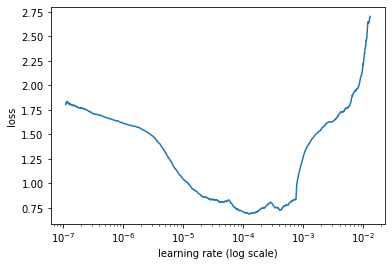

In [ ]:
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot()             # visually identify best learning rate

#### Fitting a model with fit_onecycle

In [ ]:
# Attempt 1 (no random seed fixed)
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
ERROR! Session/line number was not unique in database. History logging moved to new session 59
Train on 10223 samples, validate on 2556 samples
Epoch 1/4
10223/10223 [==============================] - 119s 12ms/sample - loss: 1.0298 - accuracy: 0.6227 - val_loss: 0.8281 - val_accuracy: 0.6952
Epoch 2/4
10223/10223 [==============================] - 118s 11ms/sample - loss: 0.7687 - accuracy: 0.7195 - val_loss: 0.7439 - val_accuracy: 0.7285
Epoch 3/4
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.6029 - accuracy: 0.7837 - val_loss: 0.7033 - val_accuracy: 0.7469
Epoch 4/4
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.4419 - accuracy: 0.8512 - val_loss: 0.7217 - val_accuracy: 0.7508


In [ ]:
# ATTEMPT 2 (with a seed fixed above)
learner.fit_onecycle(0.0001, 5)



begin training using onecycle policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 135s 13ms/sample - loss: 1.0651 - accuracy: 0.5847 - val_loss: 0.7462 - val_accuracy: 0.7285
Epoch 2/5
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.7000 - accuracy: 0.7494 - val_loss: 0.6919 - val_accuracy: 0.7547
Epoch 3/5
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.5239 - accuracy: 0.8112 - val_loss: 0.7490 - val_accuracy: 0.7457
Epoch 4/5
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.2877 - accuracy: 0.9015 - val_loss: 0.8324 - val_accuracy: 0.7477
Epoch 5/5
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.1198 - accuracy: 0.9611 - val_loss: 0.9635 - val_accuracy: 0.7555


In [ ]:
# ATTEMPT 3 (with the same random seed to check reproducibility)
# the results are not identical, but close... not reproducible well.
learner.fit_onecycle(0.0001, 5)



begin training using onecycle policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 94s 9ms/sample - loss: 1.0651 - accuracy: 0.5848 - val_loss: 0.7548 - val_accuracy: 0.7246
Epoch 2/5
10223/10223 [==============================] - 75s 7ms/sample - loss: 0.6978 - accuracy: 0.7469 - val_loss: 0.6883 - val_accuracy: 0.7547
Epoch 3/5
10223/10223 [==============================] - 77s 8ms/sample - loss: 0.5248 - accuracy: 0.8129 - val_loss: 0.7453 - val_accuracy: 0.7461
Epoch 4/5
10223/10223 [==============================] - 77s 8ms/sample - loss: 0.2939 - accuracy: 0.8999 - val_loss: 0.8197 - val_accuracy: 0.7433
Epoch 5/5
10223/10223 [==============================] - 75s 7ms/sample - loss: 0.1120 - accuracy: 0.9647 - val_loss: 0.9754 - val_accuracy: 0.7516


#### Fitting a model with autofit

In [ ]:
learner.autofit(0.0001, reduce_on_plateau=3)

early_stopping automatically enabled at patience=5


begin training using triangular learning rate policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/1024
10223/10223 [==============================] - 96s 9ms/sample - loss: 0.9960 - accuracy: 0.6182 - val_loss: 0.7116 - val_accuracy: 0.7387
Epoch 2/1024
10223/10223 [==============================] - 76s 7ms/sample - loss: 0.6362 - accuracy: 0.7746 - val_loss: 0.6984 - val_accuracy: 0.7488
Epoch 3/1024
10223/10223 [==============================] - 76s 7ms/sample - loss: 0.4669 - accuracy: 0.8329 - val_loss: 0.7179 - val_accuracy: 0.7516
Epoch 4/1024
10223/10223 [==============================] - 74s 7ms/sample - loss: 0.3322 - accuracy: 0.8827 - val_loss: 0.7977 - val_accuracy: 0.7414
Epoch 5/1024
10176/10223 [============================>.] - ETA: 0s - loss: 0.2539 - accuracy: 0.9125
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
10223/10223 [==========

In [ ]:
# learner.save_model('/content/gdrive/My Drive/DL')
# learner.save_model()

### Batch size = 32

In [ ]:
# CHANGED BATCH SIZE TO 32
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

model = ktrain.text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=32)

Is Multi-Label? False
maxlen is 30
done.


simulating training for different learning rates... this may take a few moments...
Train on 10223 samples
Epoch 1/1024
10223/10223 [==============================] - 126s 12ms/sample - loss: 1.6336 - accuracy: 0.2497
Epoch 2/1024
10223/10223 [==============================] - 114s 11ms/sample - loss: 1.0480 - accuracy: 0.6050
Epoch 3/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 1.0554 - accuracy: 0.6019
Epoch 4/1024
10223/10223 [==============================] - 110s 11ms/sample - loss: 1.6716 - accuracy: 0.2164
Epoch 5/1024
 1408/10223 [===>..........................] - ETA: 1:34 - loss: 3.9859 - accuracy: 0.2067

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


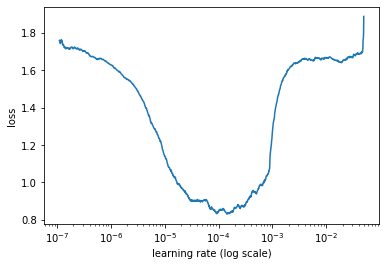

In [ ]:
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot() 

#### Fitting a model with fit_onecycle

In [ ]:
# ATTEMPT 3 (with fixed seed, smaller batches)
learner.fit_onecycle(0.0001, 7, checkpoint_folder='/content/gdrive/My Drive') 
# saved all the models but they are huge so left just after 2nd epoch and moved to LK 



begin training using onecycle policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/7
10223/10223 [==============================] - 119s 12ms/sample - loss: 1.0613 - accuracy: 0.5859 - val_loss: 0.8342 - val_accuracy: 0.6968
Epoch 2/7
10223/10223 [==============================] - 118s 12ms/sample - loss: 0.6925 - accuracy: 0.7445 - val_loss: 0.6949 - val_accuracy: 0.7531
Epoch 3/7
10223/10223 [==============================] - 117s 11ms/sample - loss: 0.5222 - accuracy: 0.8177 - val_loss: 0.7654 - val_accuracy: 0.7371
Epoch 4/7
10223/10223 [==============================] - 119s 12ms/sample - loss: 0.4157 - accuracy: 0.8540 - val_loss: 0.8122 - val_accuracy: 0.7254
Epoch 5/7
10223/10223 [==============================] - 119s 12ms/sample - loss: 0.2346 - accuracy: 0.9168 - val_loss: 0.9213 - val_accuracy: 0.7379
Epoch 6/7
10223/10223 [==============================] - 120s 12ms/sample - loss: 0.0990 - accuracy: 0.9678 - val_loss: 1.0882 - val_accu

#### Fitting a model with autofit

In [ ]:
# also saves all the epochs in separate files. epoch=2 is the best. Saved to a local drive and made predictions here.
learner.autofit(0.0001, reduce_on_plateau=3, checkpoint_folder='/content/gdrive/My Drive') 

early_stopping automatically enabled at patience=5


begin training using triangular learning rate policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/1024
10223/10223 [==============================] - 159s 16ms/sample - loss: 0.9641 - accuracy: 0.6284 - val_loss: 0.6903 - val_accuracy: 0.7563
Epoch 2/1024
10223/10223 [==============================] - 130s 13ms/sample - loss: 0.6279 - accuracy: 0.7736 - val_loss: 0.6851 - val_accuracy: 0.7527
Epoch 3/1024
10223/10223 [==============================] - 119s 12ms/sample - loss: 0.4583 - accuracy: 0.8383 - val_loss: 0.7203 - val_accuracy: 0.7477
Epoch 4/1024
10223/10223 [==============================] - 119s 12ms/sample - loss: 0.3428 - accuracy: 0.8856 - val_loss: 0.8269 - val_accuracy: 0.7336
Epoch 5/1024
10208/10223 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.9155
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
10223/10223 [==

#### Predict on a new data (for Kaggle)


In [ ]:
test.head()

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics


In [ ]:
test.iloc[34,:]


id                                                    63
title    perception concepts and language road and ipage
Name: 34, dtype: object

In [ ]:
test.iloc[43,:]

id                                                      76
title    mace language support for building distributed...
Name: 43, dtype: object

In [ ]:
test.iloc[116,:]

id                                                     242
title    probabilistic combination of text classifiers ...
Name: 116, dtype: object

In [ ]:
test.head(20)

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics
5,10,fast on line index construction by geometric p...
6,12,reasoning about rings
7,14,transductive regression piloted by inter manif...
8,15,a fast and usually linear algorithm for global...
9,16,conditional constraint satisfaction logical fo...


In [ ]:
# to predict on a new data
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
Y_new6 = predictor.predict(x_new)

In [ ]:
print(Y_new6)

['1', '1', '0', '2', '2', '1', '2', '2', '3', '2', '0', '0', '4', '1', '2', '0', '2', '2', '4', '3', '0', '0', '3', '4', '2', '0', '3', '0', '0', '0', '0', '3', '3', '4', '4', '1', '2', '3', '2', '4', '0', '1', '0', '4', '0', '3', '3', '3', '0', '2', '1', '3', '3', '3', '2', '3', '0', '3', '1', '1', '2', '3', '2', '1', '4', '2', '2', '0', '0', '4', '4', '3', '0', '3', '4', '3', '1', '3', '0', '3', '3', '1', '3', '1', '0', '0', '4', '1', '4', '2', '1', '3', '1', '1', '4', '1', '1', '0', '2', '0', '1', '4', '1', '0', '2', '2', '4', '1', '1', '1', '2', '4', '3', '4', '4', '4', '0', '4', '3', '3', '2', '0', '3', '0', '1', '1', '2', '3', '3', '4', '3', '3', '1', '2', '3', '0', '2', '1', '2', '3', '0', '3', '0', '0', '2', '4', '2', '4', '1', '2', '3', '2', '0', '2', '3', '1', '3', '4', '2', '1', '3', '1', '2', '3', '1', '0', '1', '3', '3', '4', '0', '1', '1', '0', '3', '2', '0', '0', '0', '3', '0', '1', '0', '0', '4', '3', '2', '3', '3', '1', '3', '4', '3', '0', '0', '0', '4', '0', '3', '0',

In [ ]:
test6 = pd.DataFrame(list(zip(test['id'], Y_new6)), 
               columns = ['id', 'label'])
test6
test6.to_csv('test6.csv',index=False)

## Using ktrain bert on own titles + reference titles

In [ ]:
all_df = train3[['merged','label']]

train_set, val_set = train_test_split(all_df, test_size=0.2, random_state=245)

In [ ]:
all_df.head()

,merged,label
0,interactive visual exploration of neighbor bas...,1
1,relational division four algorithms and their ...,1
2,simplifying xml schema effortless handling of ...,1
3,funbase a function based information managemen...,0
4,inverted matrix efficient discovery of frequen...,0


In [ ]:
(x_train,  y_train), (x_test, y_test), preproc = ktrain.text.texts_from_df(train_df=train_set,text_column='merged',label_columns=['label'],val_df=val_set,
                          max_features=14000, maxlen=256, preprocess_mode='bert', random_state=1)

preprocessing train...
language: en


preprocessing test...
language: en


### Batch size = 16

In [ ]:
# CHANGED BATCH SIZE TO 16 due to higher sequence length
np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 

model = ktrain.text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=16)

Is Multi-Label? False
maxlen is 256
done.


simulating training for different learning rates... this may take a few moments...
Train on 10223 samples
Epoch 1/1024
10223/10223 [==============================] - 504s 49ms/sample - loss: 1.2505 - accuracy: 0.5018
Epoch 2/1024
 8144/10223 [======================>.......] - ETA: 1:37 - loss: 1.5101 - accuracy: 0.4280

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


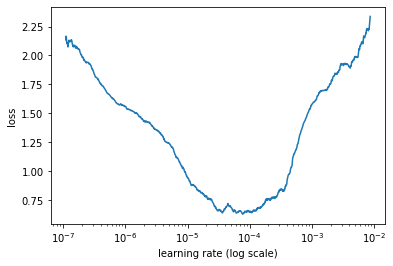

In [ ]:
learner.lr_find()             # briefly simulate training to find good learning rate
learner.lr_plot() 

#### Fitting a model with autofit

In [ ]:
# also saves all the epochs in separate files. epoch=2 is the best. Saved to a local drive and made predictions here.
learner.autofit(0.0001, reduce_on_plateau=2, checkpoint_folder='/content/gdrive/My Drive') 

early_stopping automatically enabled at patience=5


begin training using triangular learning rate policy with max lr of 0.0001...
Train on 10223 samples, validate on 2556 samples
Epoch 1/1024
10223/10223 [==============================] - 517s 51ms/sample - loss: 0.7290 - accuracy: 0.7340 - val_loss: 0.5115 - val_accuracy: 0.8118
Epoch 2/1024
10223/10223 [==============================] - 514s 50ms/sample - loss: 0.4448 - accuracy: 0.8458 - val_loss: 0.5103 - val_accuracy: 0.8149
Epoch 3/1024
10223/10223 [==============================] - 511s 50ms/sample - loss: 0.3552 - accuracy: 0.8772 - val_loss: 0.5431 - val_accuracy: 0.8005
Epoch 4/1024
10208/10223 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8973
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
10223/10223 [==============================] - 511s 50ms/sample - loss: 0.2965 - accuracy: 0.8974 - val_loss: 0.5471 - val_accuracy: 0.8130
Epoch 5/1024
10223/10223 [==

#### Predict on a new data (for Kaggle)


In [ ]:
test.head()

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics


In [ ]:
test.iloc[34,:]


id                                                    63
title    perception concepts and language road and ipage
Name: 34, dtype: object

In [ ]:
test.iloc[43,:]

id                                                      76
title    mace language support for building distributed...
Name: 43, dtype: object

In [ ]:
test.iloc[116,:]

id                                                     242
title    probabilistic combination of text classifiers ...
Name: 116, dtype: object

In [ ]:
test.head(20)

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics
5,10,fast on line index construction by geometric p...
6,12,reasoning about rings
7,14,transductive regression piloted by inter manif...
8,15,a fast and usually linear algorithm for global...
9,16,conditional constraint satisfaction logical fo...


In [ ]:
# to predict on a new data
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
Y_new6 = predictor.predict(x_new)

In [ ]:
print(Y_new6)

['1', '1', '0', '2', '2', '1', '2', '2', '3', '2', '0', '0', '4', '1', '2', '0', '2', '2', '4', '3', '0', '0', '3', '4', '2', '0', '3', '0', '0', '0', '0', '3', '3', '4', '4', '1', '2', '3', '2', '4', '0', '1', '0', '4', '0', '3', '3', '3', '0', '2', '1', '3', '3', '3', '2', '3', '0', '3', '1', '1', '2', '3', '2', '1', '4', '2', '2', '0', '0', '4', '4', '3', '0', '3', '4', '3', '1', '3', '0', '3', '3', '1', '3', '1', '0', '0', '4', '1', '4', '2', '1', '3', '1', '1', '4', '1', '1', '0', '2', '0', '1', '4', '1', '0', '2', '2', '4', '1', '1', '1', '2', '4', '3', '4', '4', '4', '0', '4', '3', '3', '2', '0', '3', '0', '1', '1', '2', '3', '3', '4', '3', '3', '1', '2', '3', '0', '2', '1', '2', '3', '0', '3', '0', '0', '2', '4', '2', '4', '1', '2', '3', '2', '0', '2', '3', '1', '3', '4', '2', '1', '3', '1', '2', '3', '1', '0', '1', '3', '3', '4', '0', '1', '1', '0', '3', '2', '0', '0', '0', '3', '0', '1', '0', '0', '4', '3', '2', '3', '3', '1', '3', '4', '3', '0', '0', '0', '4', '0', '3', '0',

In [ ]:
test6 = pd.DataFrame(list(zip(test['id'], Y_new6)), 
               columns = ['id', 'label'])
test6
test6.to_csv('test6.csv',index=False)